# BASELINE MODEL

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy as np
import scipy
import sys
from scipy import io
import math
import random
import keras
from sklearn import preprocessing
from glob import glob
import tqdm

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 12]


# GLOBALS

In [2]:
POET_DIR = "D:/data/POETdataset/"
PATCHES_FILE = os.path.join(POET_DIR, "x.npy")
LABELS_FILE = os.path.join(POET_DIR, 'y.npy')
pascal_images = os.path.join(POET_DIR, 'PascalImages')
PATCH_SIZE = 32
HALF_PATCH = PATCH_SIZE//2
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
MAX_GAZE_POINTS = 3 # TEMPORARY
MIN_GAZE_POINTS = 3
VGG_NR_FEATURES = 512
user_index = 0 # TEMPORARY
BATCH_SIZE = 50
IMG_SIZE = 224

In [3]:
os.chdir(POET_DIR)

# DATA 

In [4]:
classes = [a.split("_")[1].split(".mat")[0] for a in glob("etData/*")]
idx2class = {i:c for i, c in enumerate(classes)}
class2idx = {c:i for i, c in enumerate(classes)}

In [5]:
learned_model = keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='max')
pp_func = keras.applications.resnet50.preprocess_input

features_extractor_model = keras.models.Sequential()
features_extractor_model.add(keras.layers.Lambda(pp_func,name='preprocessing',input_shape=(IMG_SIZE,IMG_SIZE,3)))
features_extractor_model.add(learned_model)


## We store the feature vectors for each image

In [6]:
classes

['aeroplane',
 'bicycle',
 'boat',
 'cat',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'sofa']

### We ignore the items with too few fixations

In [7]:
dropped_list = np.load('dropped_list.npy')

In [8]:
dropped_list = [os.path.abspath(p) for p in dropped_list]

In [9]:
x = []
y = []
for i, cname in enumerate(tqdm.tqdm(classes)):
    print(cname)
    class_files = glob("PascalImages/%s*" %cname)
    class_files = [os.path.abspath(f) for f in class_files]
    class_files = [f for f in class_files if f not in dropped_list]
    files_loaded = [keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(file_, target_size=(IMG_SIZE, IMG_SIZE, 3))
    ) 
                    for file_ in class_files
                   ]
    feature_vec = features_extractor_model.predict(np.array(files_loaded),verbose=1)
    x.append(feature_vec)
    y.append([class2idx[cname]]*len(class_files))
x = np.concatenate(x)
y = np.concatenate(y)
                                                           

  0%|                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

aeroplane
666/666 [==============================] - 9s 14ms/step


 10%|██████████████▌                                                                                                                                   | 1/10 [00:11<01:45, 11.78s/it]

bicycle
535/535 [==============================] - 5s 9ms/step


 20%|█████████████████████████████▏                                                                                                                    | 2/10 [00:19<01:24, 10.55s/it]

boat
503/503 [==============================] - 4s 9ms/step


 30%|███████████████████████████████████████████▊                                                                                                      | 3/10 [00:26<01:05,  9.36s/it]

cat
1050/1050 [==============================] - 9s 9ms/step


 40%|██████████████████████████████████████████████████████████▍                                                                                       | 4/10 [00:39<01:04, 10.67s/it]

cow
301/301 [==============================] - 3s 10ms/step


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 5/10 [00:44<00:44,  8.81s/it]

diningtable
498/498 [==============================] - 5s 9ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6/10 [00:51<00:33,  8.28s/it]

dog
1255/1255 [==============================] - 11s 9ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7/10 [01:08<00:32, 10.88s/it]

horse
480/480 [==============================] - 4s 9ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8/10 [01:14<00:19,  9.56s/it]

motorbike
509/509 [==============================] - 5s 10ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9/10 [01:22<00:08,  8.89s/it]

sofa
466/466 [==============================] - 4s 9ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.08s/it]


In [10]:
x.shape

(6263, 2048)

In [11]:
y[0]

0

In [12]:
np.save('baselinemodel-images-features.npy',x)

In [13]:
np.save('baselinemodel-labels.npy',y)

(array([ 666.,  535.,  503., 1050.,  301.,  498., 1255.,  480.,  509.,
         466.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

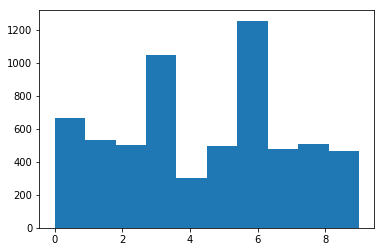

In [14]:
plt.hist(y)

In [15]:
X_img = np.zeros((len(x), IMG_SIZE, IMG_SIZE, 3))

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [17]:
enc = OneHotEncoder()
y = y.reshape(-1,1)
enc.fit(y)
y_onehot = enc.transform(y)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [18]:
np.save('y.npy', y_onehot)

In [19]:
x.shape

(6263, 2048)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x, y_onehot.todense(), test_size=0.1, stratify=y_onehot.todense())

# MODEL

In [22]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=128, activation='relu', input_shape=(2048,)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(units=10, activation='softmax'))
optm = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
                optimizer=optm,
                metrics=['accuracy'],)

In [23]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_data=(X_test, y_test),    
    epochs=200
)

Train on 5636 samples, validate on 627 samples
Epoch 1/200
5636/5636 [==============================] - 2s 333us/step - loss: 9.4495 - acc: 0.3817 - val_loss: 6.9487 - val_acc: 0.5040
Epoch 2/200
5636/5636 [==============================] - 1s 122us/step - loss: 2.0461 - acc: 0.5296 - val_loss: 0.8530 - val_acc: 0.7081
Epoch 3/200
5636/5636 [==============================] - 1s 127us/step - loss: 1.0495 - acc: 0.6334 - val_loss: 0.7930 - val_acc: 0.7129
Epoch 4/200
5636/5636 [==============================] - 1s 124us/step - loss: 0.8915 - acc: 0.6987 - val_loss: 0.7272 - val_acc: 0.7671
Epoch 5/200
5636/5636 [==============================] - 1s 127us/step - loss: 0.8150 - acc: 0.7163 - val_loss: 0.7063 - val_acc: 0.7831
Epoch 6/200
5636/5636 [==============================] - 1s 127us/step - loss: 0.7974 - acc: 0.7344 - val_loss: 0.7058 - val_acc: 0.7815
Epoch 7/200
5636/5636 [==============================] - 1s 127us/step - loss: 0.7531 - acc: 0.7319 - val_loss: 0.6743 - val_acc: 0

# Plot history

In [24]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

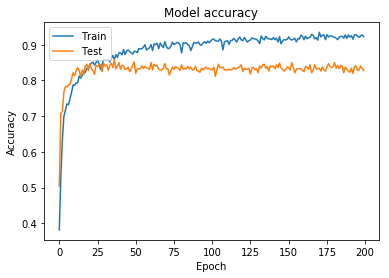

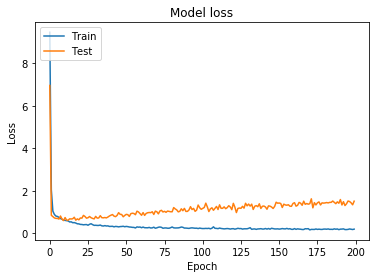

In [25]:
plot_history(history)

Normalized confusion matrix


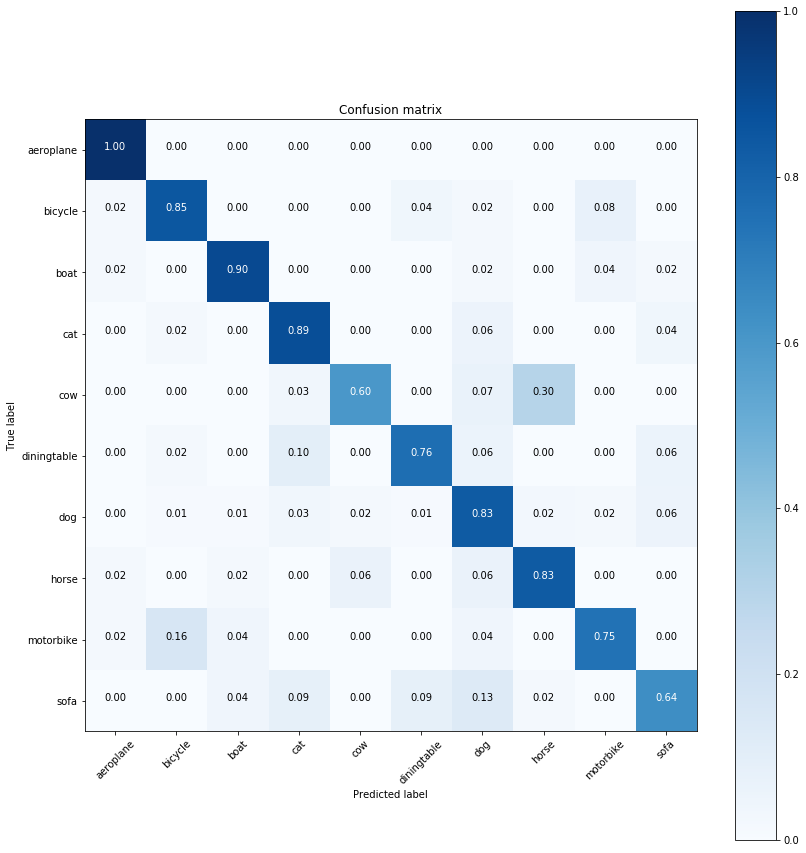

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

from sklearn.metrics import confusion_matrix

y_pred_proba = model.predict(X_test)

y_pred = np.argmax(y_pred_proba, axis=1)

y_test_argmax = np.argmax(y_test, axis=1)

y_test_argmax.shape

cnf_matrix = confusion_matrix(y_test_argmax, y_pred)

import itertools

plot_confusion_matrix(cnf_matrix, class2idx.keys(), normalize=True)

In [30]:
np.save('baseline-cnf_matrix', cnf_matrix)

# Comparison

In [31]:
cnf_matrix_model = np.load('model-cnf_matrix.npy')

In [36]:
cnf_matrix

array([[ 67,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  45,   0,   0,   0,   2,   1,   0,   4,   0],
       [  1,   0,  45,   0,   0,   0,   1,   0,   2,   1],
       [  0,   2,   0,  93,   0,   0,   6,   0,   0,   4],
       [  0,   0,   0,   1,  18,   0,   2,   9,   0,   0],
       [  0,   1,   0,   5,   0,  38,   3,   0,   0,   3],
       [  0,   1,   1,   4,   2,   1, 105,   3,   2,   7],
       [  1,   0,   1,   0,   3,   0,   3,  40,   0,   0],
       [  1,   8,   2,   0,   0,   0,   2,   0,  38,   0],
       [  0,   0,   2,   4,   0,   4,   6,   1,   0,  30]], dtype=int64)

In [37]:
cnf_matrix_model

array([[ 63,   1,   1,   0,   0,   0,   0,   0,   1,   1],
       [  2,  45,   2,   1,   0,   0,   0,   0,   3,   0],
       [  2,   0,  46,   0,   0,   1,   1,   0,   0,   0],
       [  0,   1,   0,  92,   1,   0,   9,   0,   0,   2],
       [  0,   0,   0,   0,  25,   0,   2,   3,   0,   0],
       [  0,   0,   1,   0,   0,  46,   1,   0,   0,   2],
       [  0,   0,   0,   2,   0,   2, 120,   1,   0,   1],
       [  1,   0,   1,   0,   9,   0,   3,  34,   0,   0],
       [  1,   4,   1,   0,   1,   1,   2,   0,  41,   0],
       [  0,   0,   0,   2,   0,  16,   5,   0,   0,  24]], dtype=int64)

In [39]:
diff_cnf_matrix = cnf_matrix - cnf_matrix_model

Confusion matrix, without normalization


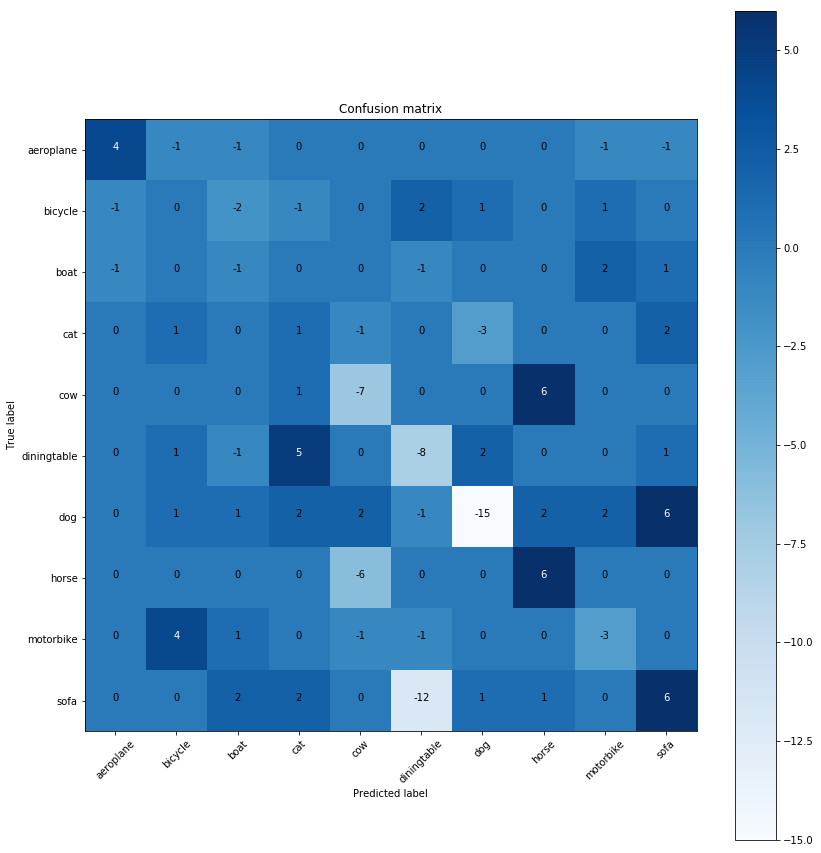

In [40]:
plot_confusion_matrix(diff_cnf_matrix, class2idx.keys())